In [1]:
pip install pandas numpy scikit-learn dowhy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

# Load the ratings data
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Load user information
users = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Load movie information
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', header=None)


In [4]:
print(ratings.head())   # Shows first 5 rows of ratings
print(users.head())     # Shows first 5 rows of user info
print(movies.head())    # Shows first 5 rows of movie info

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213
   0                  1            2   3   \
0   1   Toy Story (1995)  01-Jan-1995 NaN   
1   2   GoldenEye (1995)  01-Jan-1995 NaN   
2   3  Four Rooms (1995)  01-Jan-1995 NaN   
3   4  Get Shorty (1995)  01-Jan-1995 NaN   
4   5     Copycat (1995)  01-Jan-1995 NaN   

                                                  4   5   6   7   8   9   ...  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...   0   0   0   1   1  ...   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...   0   1   1   0 

In [5]:
data = pd.merge(ratings, users, on='user_id')

print(data.head())

   user_id  item_id  rating  timestamp  age gender  occupation zip_code
0      196      242       3  881250949   49      M      writer    55105
1      186      302       3  891717742   39      F   executive    00000
2       22      377       1  878887116   25      M      writer    40206
3      244       51       2  880606923   28      M  technician    80525
4      166      346       1  886397596   47      M    educator    55113


In [6]:
# Encode user_id and item_id as categorical codes (safe practice)
data['user_id_encoded'] = data['user_id'].astype('category').cat.codes
data['item_id_encoded'] = data['item_id'].astype('category').cat.codes

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=42)

In [8]:
# Calculate mean rating for each movie based on training data
mean_ratings = train.groupby('item_id_encoded')['rating'].mean()

# Predict for test set
test['pred_rating'] = test['item_id_encoded'].map(mean_ratings)

# Fill missing predictions with global mean rating
global_mean = train['rating'].mean()
test['pred_rating'].fillna(global_mean, inplace=True)

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['rating'], test['pred_rating']))
print(f'Baseline RMSE: {rmse}')

Baseline RMSE: 1.0209640682297232


In [10]:
import dowhy
from dowhy import CausalModel

In [11]:
causal_model = CausalModel(
    data=data,
    treatment='gender',      # Sensitive attribute we suspect may cause bias
    outcome='rating',        # The recommendation output
    common_causes=['age', 'occupation']  # Other factors affecting rating
)

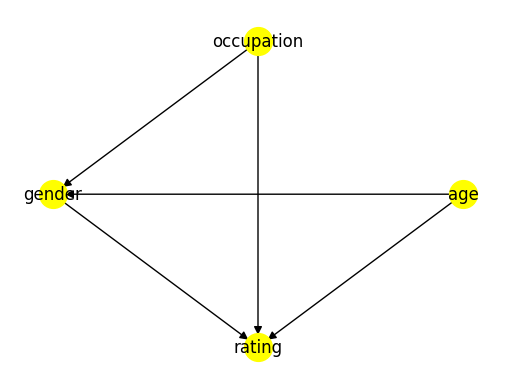

In [12]:
causal_model.view_model()

In [13]:
identified_estimand = causal_model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
─────────(E[rating|age,occupation])
d[gender]                          
Estimand assumption 1, Unconfoundedness: If U→{gender} and U→rating then P(rating|gender,age,occupation,U) = P(rating|gender,age,occupation)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [15]:
print(data['gender'].unique())

['M' 'F']


In [16]:
# Convert to binary (0 for Female, 1 for Male)
data['gender'] = data['gender'].map({'M': 1, 'F': 0})


In [17]:
print(data['gender'].unique())

[1 0]


In [18]:
causal_estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
─────────(E[rating|age,occupation])
d[gender]                          
Estimand assumption 1, Unconfoundedness: If U→{gender} and U→rating then P(rating|gender,age,occupation,U) = P(rating|gender,age,occupation)

## Realized estimand
b: rating~gender+age+occupation
Target units: ate

## Estimate
Mean value: -0.07513989133881749



In [19]:
refutation = causal_model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter")
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-0.07513989133881749
New effect:-1.9984014443252818e-14
p value:0.0



In [20]:
causal_estimate2 = causal_model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(causal_estimate2)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                              
─────────(E[rating|age,occupation])
d[gender]                          
Estimand assumption 1, Unconfoundedness: If U→{gender} and U→rating then P(rating|gender,age,occupation,U) = P(rating|gender,age,occupation)

## Realized estimand
b: rating~gender+age+occupation
Target units: ate

## Estimate
Mean value: -0.07513989133881749



In [21]:
refutation1 = causal_model.refute_estimate(
    identified_estimand, causal_estimate2, method_name="random_common_cause"
)
print(refutation1)

refutation2 = causal_model.refute_estimate(
    identified_estimand, causal_estimate2, method_name="data_subset_refuter"
)
print(refutation2)

refutation3 = causal_model.refute_estimate(
    identified_estimand, causal_estimate2, method_name="placebo_treatment_refuter"
)
print(refutation3)

Refute: Add a Random Common Cause
Estimated effect:-0.07513989133881749
New effect:-0.07516592431495228

Refute: Use a subset of data
Estimated effect:-0.07513989133881749
New effect:-0.07436507758339514
p value:0.42

Refute: Use a Placebo Treatment
Estimated effect:-0.07513989133881749
New effect:-1.9984014443252818e-14
p value:0.0



In [22]:

# Fairness Metrics using fairlearn
# The code below requires the 'fairlearn' package. If you do not have it installed, please install it using:
# !pip install fairlearn
!pip install fairlearn
import fairlearn

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score
import numpy as np

# Binarize rating (modify threshold based on your needs)
data['rating_binary'] = np.where(data['rating'] >= 3, 1, 0)

# True and predicted outcomes (replace y_pred with actual model output if available)
y_true = data['rating_binary']
y_pred = data['rating_binary']  # For demonstration, assuming perfect prediction
sensitive_feature = data['gender']

# Fairness Metric Frame
metric_frame = MetricFrame(
    metrics={
        'selection_rate': selection_rate,
        'accuracy': accuracy_score
    },
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

print(metric_frame)

# Group Fairness Differences
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature)

print(f"\nDemographic Parity Difference: {dp_diff:.4f}")
print(f"Equalized Odds Difference: {eo_diff:.4f}")

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import accuracy_score
import numpy as np

# Binarize rating (modify threshold based on your needs)
data['rating_binary'] = np.where(data['rating'] >= 3, 1, 0)

# True and predicted outcomes (replace y_pred with actual model output if available)
y_true = data['rating_binary']
y_pred = data['rating_binary']  # For demonstration, assuming perfect prediction
sensitive_feature = data['gender']

# Fairness Metric Frame
metric_frame = MetricFrame(
    metrics={
        'selection_rate': selection_rate,
        'accuracy': accuracy_score
    },
    y_true=y_true,
    y_pred=y_pred,
    sensitive_features=sensitive_feature
)

print(metric_frame)

# Group Fairness Differences
dp_diff = demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_feature)
eo_diff = equalized_odds_difference(y_true, y_pred, sensitive_features=sensitive_feature)

print(f"\nDemographic Parity Difference: {dp_diff:.4f}")
print(f"Equalized Odds Difference: {eo_diff:.4f}")



Demographic Parity Difference: 0.0093
Equalized Odds Difference: 0.0000

Demographic Parity Difference: 0.0093
Equalized Odds Difference: 0.0000
